# Global Forecasting Models: Time series with different lengths and different exogenous variables

When faced with a multi-series forecasting problem, it is common for the series to have varying lengths due to differences in the starting times of data recording. To address this scenario, the class [ForecasterRecursiveMultiSeries](../user_guides/independent-multi-time-series-forecasting.html) allows the simultaneous modeling of time series of different lengths and using different exogenous variables.

+ When the modeled series have different lengths, they must be stored in a Python dictionary. The keys of the dictionary are the names of the series and the values are the series themselves. All series must be of type `pandas.Series`, have a `pandas.DatetimeIndex` with the **same frequency**.


| Series values                            | Allowed |
|:----------------------------------------:|:-------:|
| `[NaN, NaN, NaN, NaN, 4, 5, 6, 7, 8, 9]` |✔️       |
| `[0, 1, 2, 3, 4, 5, 6, 7, 8, NaN]`       |✔️       |
| `[0, 1, 2, 3, 4, NaN, 6, 7, 8, 9]`       |✔️       |
| `[NaN, NaN, 2, 3, 4, NaN, 6, 7, 8, 9]`   |✔️       |

+ When different exogenous variables are used for each series, or if the exogenous variables are the same but have different values for each series, they must be stored in a dictionary. The keys of the dictionary are the names of the series and the values are the exogenous variables themselves. All exogenous variables must be of type `pandas.DataFrame` or `pandas.Series` and have a `pandas.DatetimeIndex` with the **same frequency**.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

API Reference <a href="../api/forecasterrecursivemultiseries.html">ForecasterRecursiveMultiSeries</a>.

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict, exog_long_to_dict, RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)

The data for this example is stored in **"long format"** in a single `DataFrame`. The `series_id` column identifies the series to which each observation belongs. The `timestamp` column contains the date of the observation, and the `value` column contains the value of the series at that date. Each time series is of a different length.

The exogenous variables are stored in a separate `DataFrame`, also in **"long format"**. The column `series_id` identifies the series to which each observation belongs. The column `timestamp` contains the date of the observation, and the remaining columns contain the values of the exogenous variables at that date.

In [2]:
# Load time series of multiple lengths and exogenous variables
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head())
print("")
display(exog.head())

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099
3,id_1000,2016-01-04,1675.750496
4,id_1000,2016-01-05,1586.250694


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064
3,id_1000,2016-01-04,0.000000,1.000000,6.704778,4.865404
4,id_1000,2016-01-05,0.781831,0.623490,2.392998,5.228913


When series have different lengths, the data must be transformed into a dictionary. The keys of the dictionary are the names of the series and the values are the series themselves. To do this, the `series_long_to_dict` function is used, which takes the `DataFrame` in "long format" and returns a `dict` of `pandas Series`.

Similarly, when the exogenous variables are different (values or variables) for each series, the data must be transformed into a dictionary. The keys of the dictionary are the names of the series and the values are the exogenous variables themselves. The `exog_long_to_dict` function is used, which takes the `DataFrame` in "long format" and returns a `dict` of exogenous variables (`pandas Series` or `pandas DataFrame`).

In [3]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ Series 'id_1003' is incomplete. NaNs have been introduced after setting the          │
│ frequency.                                                                           │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\anaconda\envs\skforecast_15_p12\Lib\site-packages\skforecast\preprocessing\prepro │
│ cessing.py:428                                                                       │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Some exogenous variables are omitted for series 1 and 3 to illustrate that different exogenous variables can be used for each series.

In [4]:
# Drop some exogenous variables for series 'id_1000' and 'id_1003'
# ==============================================================================
exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [5]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

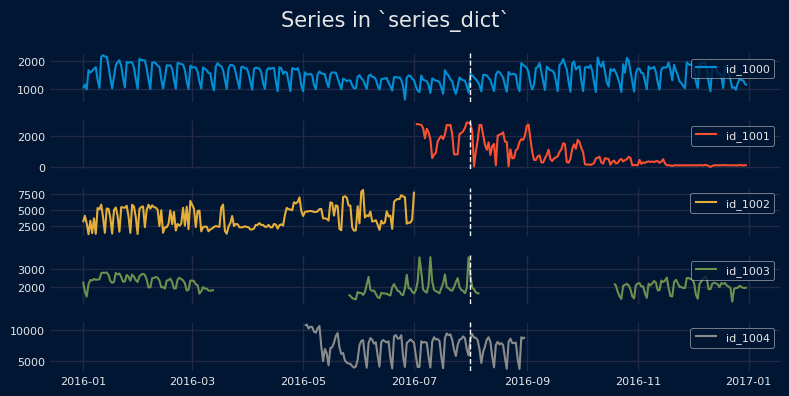

In [6]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train

fig.suptitle('Series in `series_dict`', fontsize=15)
plt.tight_layout()

In [7]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print("\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print("\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [8]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print("\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Train and predict

The `fit` method is used to train the model, it is passed the dictionary of series and the dictionary of exogenous variables where the keys of each dictionary are the names of the series.

In [9]:
# Fit forecaster
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14])
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 window_features    = window_features,
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: ['roll_mean_7', 'roll_mean_14'] 
Window size: 14 
Series encoding: ordinal 
Series names (levels): id_1000, id_1001, id_1002, id_1003, id_1004 
Exogenous included: True 
Exogenous names: 
    sin_day_of_week, cos_day_of_week, air_temperature, wind_speed 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02',
    '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], 'id_1003':
    ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-05-02', '2016-07-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-07 12:49:34 
Last fit date: 2025-03-07 12:49:35 
Skforecast version: 0.15.0 
Python version: 3.12.9 
Forecaster id: None

Only series whose last window of data ends at the same datetime index can be predicted together. If `levels = None`, series that do not reach the maximum index are excluded from prediction. In this example, series `'id_1002'` is excluded because it does not reach the maximum index.

In [10]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions

,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
2016-08-02,id_1001,2947.579536
2016-08-02,id_1003,2310.075968
2016-08-02,id_1004,8685.425990
2016-08-03,id_1000,1410.151437
2016-08-03,id_1001,2875.847691


## Missing values in the series

When working with time series of different lengths, it is common for some series to have missing values. As not all the regressors allow missing values, the argument `dropna_from_series` can be used to remove the missing values from the training matrices. 

- If `False`, leave NaNs in `X_train` and warn the user. (default)

- If `True`, drop NaNs in `X_train` and same rows in `y_train` and warn the user.

`y_train` NaNs (and same rows from `X_train`) are always dropped because the target variable cannot have NaN values.

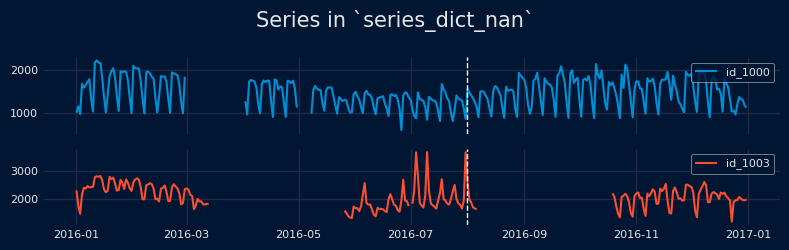

In [11]:
# Sample data with interspersed NaNs
# ==============================================================================
series_dict_nan = {
    'id_1000': series_dict['id_1000'].copy(),
    'id_1003': series_dict['id_1003'].copy()
}

# Create NaNs
series_dict_nan['id_1000'].loc['2016-03-01':'2016-04-01',] = np.nan
series_dict_nan['id_1000'].loc['2016-05-01':'2016-05-07',] = np.nan
series_dict_nan['id_1003'].loc['2016-07-01',] = np.nan

# Plot series
# ==============================================================================
fig, axs = plt.subplots(2, 1, figsize=(8, 2.5), sharex=True)

for i, s in enumerate(series_dict_nan.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train

fig.suptitle('Series in `series_dict_nan`', fontsize=15)
plt.tight_layout()

When `dropna_from_series = False`, the NaNs in `X_train` are kept and the user is warned. This is useful if the user wants to keep the NaNs in the series and use a regressor that can handle them.

In [12]:
# Create Matrices, dropna_from_series = False
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 3, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

X, y = forecaster.create_train_X_y(series=series_dict_nan)

display(X.head(3))
print("Observations per series:")
print(X['_level_skforecast'].value_counts())
print("")
print("NaNs per series:")
print(X.isnull().sum())

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `y_train`. They have been dropped because the target variable       │
│ cannot have NaN values. Same rows have been dropped from `X_train` to maintain       │
│ alignment. This is caused by series with interspersed NaNs.                          │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\anaconda\envs\skforecast_15_p12\Lib\site-packages\skforecast\recursive\_forecaste │
│ r_recursive_multiseries.py:1190                                                      │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. Some regressors do not allow NaN values during training. │
│ If you want to drop them, set `forecaster.dropna_from_series = True`.                │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\anaconda\envs\skforecast_15_p12\Lib\site-packages\skforecast\recursive\_forecaste │
│ r_recursive_multiseries.py:1212                                                      │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,lag_1,lag_2,lag_3,_level_skforecast
2016-01-04,983.000099,1158.500099,1012.500694,0
2016-01-05,1675.750496,983.000099,1158.500099,0
2016-01-06,1586.250694,1675.750496,983.000099,0


Observations per series:
_level_skforecast
0    324
1    216
Name: count, dtype: int64

NaNs per series:
lag_1                 5
lag_2                 9
lag_3                13
_level_skforecast     0
dtype: int64


When `dropna_from_series = True`, the NaNs in `X_train` are removed and the user is warned. This is useful if the user chooses a regressor that cannot handle missing values.

In [13]:
# Create Matrices, dropna_from_series = False
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 3, 
                 encoding           = "ordinal", 
                 dropna_from_series = True
             )

X, y = forecaster.create_train_X_y(series=series_dict_nan)

display(X.head(3))
print("Observations per series:")
print(X['_level_skforecast'].value_counts())
print("")
print("NaNs per series:")
print(X.isnull().sum())

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `y_train`. They have been dropped because the target variable       │
│ cannot have NaN values. Same rows have been dropped from `X_train` to maintain       │
│ alignment. This is caused by series with interspersed NaNs.                          │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\anaconda\envs\skforecast_15_p12\Lib\site-packages\skforecast\recursive\_forecaste │
│ r_recursive_multiseries.py:1190                                                      │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\anaconda\envs\skforecast_15_p12\Lib\site-packages\skforecast\recursive\_forecaste │
│ r_recursive_multiseries.py:1203                                                      │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,lag_1,lag_2,lag_3,_level_skforecast
2016-01-04,983.000099,1158.500099,1012.500694,0
2016-01-05,1675.750496,983.000099,1158.500099,0
2016-01-06,1586.250694,1675.750496,983.000099,0


Observations per series:
_level_skforecast
0    318
1    207
Name: count, dtype: int64

NaNs per series:
lag_1                0
lag_2                0
lag_3                0
_level_skforecast    0
dtype: int64


During the training process, the warnings can be suppressed by setting `suppress_warnings = True`.

In [14]:
# Suppress warnings during fit method
# ==============================================================================
forecaster.fit(series=series_dict_nan, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Series encoding: ordinal 
Series names (levels): id_1000, id_1003 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-12-31'], 'id_1003': ['2016-01-01', '2016-12-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-07 12:49:41 
Last fit date: 2025-03-07 12:49:42 
Skforecast version: 0.15.0 
Python version: 3.12.9 
Forecaster id: None

## Backtesting

Similar to the `predict` method, you need to specify the `levels` for [backtesting](../user_guides/backtesting.html). When backtesting time series of varying lengths, two key behaviors should be noted:

+ Handling missing values in the Series: The backtesting process only provides predictions for the date-times available in the series. If there are gaps in the validation or test set, predictions for those missing periods will not be generated. This ensures that metrics are not skewed by missing values, as no true values are available for those date-times.

+ Size of the training set: The `initial_train_size` is applied starting from the first date-time observed among all series. For series that begin later than others, the training will include less data. 

In [15]:
# Backtesting
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(series_dict_train["id_1000"])
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    cv                    = cv,
    levels                = None,
    metric                = "mean_absolute_error",
    add_aggregated_metric = True,
    suppress_warnings     = True
)

display(metrics_levels)
backtest_predictions

  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,id_1000,167.502214
1,id_1001,1103.313887
2,id_1002,NaN
3,id_1003,280.492603
4,id_1004,711.078359
5,average,565.596766
6,weighted_average,572.944127
7,pooling,572.944127


,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
...,...,...
2016-12-30,id_1001,1132.535774
2016-12-30,id_1003,2089.261345
2016-12-31,id_1000,1393.128313
2016-12-31,id_1001,1106.034061


Note that if a series has no observations in the test set, the backtesting process will not return any predictions for that series and the metric will be `NaN`, as happened with series `'id_1002'`.

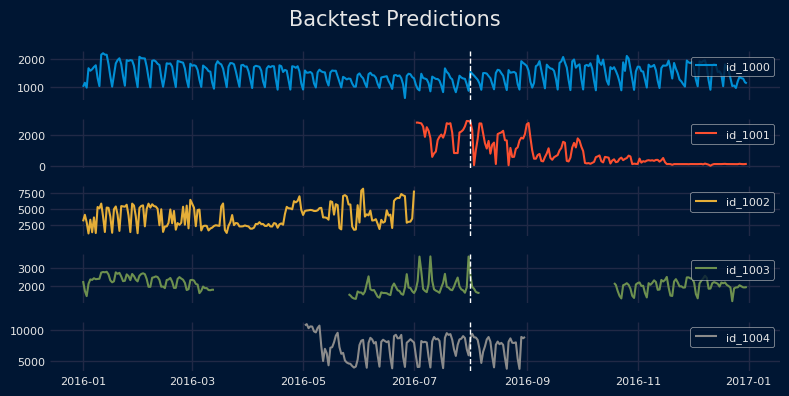

In [16]:
# Plot backtesting predictions
# ==============================================================================
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

fig.suptitle('Backtest Predictions', fontsize=15)
plt.tight_layout()

## Hyperparameter tuning and lags selection

The `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` functions in the `model_selection` module allow for lags and hyperparameter optimization. It is performed using the backtesting strategy for validation as in other Forecasters.

When using series of different lengths, the metric is calculated as a **weighted average** of the backtesting metrics of the selected series (levels) and their number of predictions.

More information about: [Hyperparameter tuning and lags selection Multi-Series](../user_guides/independent-multi-time-series-forecasting.html#hyperparameter-tuning-and-lags-selection-multi-series).

In [17]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1), 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 30),
        'max_depth'       : trial.suggest_int('max_depth', 3, 7)
    }

    return search_space

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(series_dict_train["id_1000"]),
     )

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster        = forecaster,
    series            = series_dict,
    exog              = exog_dict,
    search_space      = search_space,
    cv                = cv,
    levels            = None,
    metric            = 'mean_absolute_error',
    n_trials          = 10,
    suppress_warnings = True
)

results.head(4)

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'min_samples_leaf': 29, 'max_depth': 5}
  Backtesting metric: 531.5731935466865
  Levels: ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']



,levels,lags,params,mean_absolute_error__weighted_average,mean_absolute_error__average,mean_absolute_error__pooling,min_samples_leaf,max_depth
0,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 29, 'max_depth': 5}",531.573194,510.885119,510.885119,29,5
1,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 11, 'max_depth': 5}",542.700963,557.169748,557.169748,11,5
2,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 18, 'max_depth': 4}",572.011630,559.198862,559.198862,18,4
3,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7]","{'min_samples_leaf': 30, 'max_depth': 6}",591.817179,595.234722,595.234722,30,6


## Categorical variables

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Starting with version <code>0.13.0</code>, the <code>ForecasterRecursiveMultiSeries</code> class can use <code>encoding='ordinal_category'</code> for encoding time series identifiers. This approach creates a new column (<i>_level_skforecast</i>) of type pandas <code>category</code>. Consequently, the regressors must be able to handle categorical variables. If the regressors do not support categorical variables, the user should set the encoding to <code>'ordinal'</code> or <code>'onehot'</code> for compatibility.

<p>Some examples of regressors that support categorical variables and how to enable them are:</p>

<strong>HistGradientBoostingRegressor</strong> 

```python
HistGradientBoostingRegressor(categorical_features="from_dtype")
```

<strong>LightGBM</strong>

<code>LGBMRegressor</code> does not allow configuration of categorical features during initialization, but rather in its <code>fit</code> method. Therefore, use Forecaster' argument <code>fit_kwargs = {'categorical_feature':'auto'}</code>. This is the default behavior of <code>LGBMRegressor</code> if no indication is given.

<strong>XGBoost</strong>
```python
XGBRegressor(enable_categorical=True)
```

</div>